In [0]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import SpectralClustering 
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import scipy.linalg as spla
import scipy.spatial
from collections import Counter


In [0]:
! pip install bcubed
!pip install pyamg

In [0]:
import bcubed

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### prep data

In [0]:
def load_data(path):
    doc_data1 = pd.read_csv(path, header = None)
    print(len(doc_data1))
    return doc_data1

In [0]:
def normalize(data):
    sentences = (data[0].str.lower() #lowercase
                           .str.replace(r'[^\w\s]+', '') #rem punctuation 
                          .str.strip()) #rem trailing whitespaces
    return sentences

In [0]:
def get_embedd(data):
  vectorizer = CountVectorizer()
  X1 = vectorizer.fit_transform(data) # corpus
  X1 = X1.toarray()
  return X1

In [0]:
def get_fscore(result, dict_lables):
  result = result.tolist()
  dictOf_cluster_lables = { i : {result[i]} for i in range(0, len(result) ) }

  precision = bcubed.precision(dictOf_cluster_lables, dict_lables)
  recall = bcubed.recall(dictOf_cluster_lables, dict_lables)
  fscore = bcubed.fscore(precision, recall)
  return fscore
  # print("F-BCubed: %0.3f"
  #       %fscore)

In [0]:
def silhouette(all_data, X, labels, method = "kmeans", k_from = 2, k_to = 10, step = 1):
  try:
    if (method == "spectr_precomp"):
      matrix = get_matrix(X)
    
    if method in ("kmeans", "spectr", "spectr_precomp", "aglom_complete", "aglom_average"):
      sil = []
      for k in range(k_from, k_to, step ):
            if method == "kmeans":
              kmeans = KMeans(n_clusters = k).fit(X)
              labels = kmeans.labels_
            elif method == "spectr":
              spectr = SpectralClustering(n_clusters=k, affinity="rbf", gamma=0.01,eigen_solver = 'amg',n_init=20).fit(X)
              labels = spectr.labels_
            elif method == "spectr_precomp":
              spectr_prec = SpectralClustering(n_clusters=k, affinity="precomputed", gamma=0.01).fit(matrix)
              labels = spectr_prec.labels_
            elif method == "aglom_complete":
              aglom= AgglomerativeClustering(n_clusters = k, linkage = "complete", affinity = "cosine").fit(X)
              labels = aglom.labels_
            elif method == "aglom_average":
              aglom= AgglomerativeClustering(n_clusters = k, linkage = "average", affinity = "cosine").fit(X)
              labels = aglom.labels_

            sil.append(metrics.silhouette_score(X, labels, metric = 'cosine'))

    plt.plot(range(k_from, k_to, step), sil, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$');

    for i in range(0,len(sil)):
        if sil[i]==max(sil):
            rez = i
    return (k_from +rez*step)
  except:
          print("You can use kmeans, spectr, spectr_precomp, aglom_complete, aglom_average")


In [0]:
def max_f(all_data, X, labels, method = "kmeans", k_from = 2, k_to = 10, step = 1):
  try:
    if ((method == "spectr_precomp") or ()):
      matrix = get_matrix(X)
    
    if method in ("kmeans", "spectr", "spectr_precomp", "aglom_complete", "aglom_average"):
      f_scores = []
      for k in range(k_from, k_to, step ):
            if method == "kmeans":
              cluster = KMeans(n_clusters = k).fit(X)
            elif method == "spectr":
              cluster = SpectralClustering(n_clusters=k, affinity="rbf", gamma=0.01,eigen_solver = 'amg',n_init=20).fit(X)
            elif method == "spectr_precomp":
              cluster = SpectralClustering(n_clusters=k, affinity="precomputed", gamma=0.01).fit(matrix)
            elif method == "aglom_complete":
              cluster = AgglomerativeClustering(n_clusters = k, linkage = "complete", affinity = "cosine").fit(X)
            elif method == "aglom_average":
              cluster = AgglomerativeClustering(n_clusters = k, linkage = "average", affinity = "cosine").fit(X)
              
            labels = cluster.labels_
            f_scores.append(get_fscore(labels, dict_lables))
    
    plt.plot(range(k_from, k_to, step), f_scores, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$');

    return max(f_scores)
  except:
    print("You can use kmeans, spectr, spectr_precomp, aglom_complete, aglom_average")

In [0]:
def kmeans_result(X, true_k):
    clustering_model = KMeans( n_clusters=true_k)
    clustering_model.fit(X)
    cluster_assignment = clustering_model.labels_
    print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, cluster_assignment, metric='cosine', sample_size=len(X)))
    return cluster_assignment

In [0]:
from scipy.spatial.distance import cosine

def get_matrix(my_data):
  length = my_data.shape[0]
  da = np.zeros((length, length))
  pairs = [(i, j) for i in range(length) for j in range(i+1, length)]
  for i, j in (pairs):
      dist = 1 - cosine(my_data[i], my_data[j])
      da[i, j] = da[j, i] = dist
  return da

### data

In [0]:
true_data = load_data('/content/drive/My Drive/Step2/slf_full.csv')
labels = true_data[2]

226


In [0]:
data1 = normalize(true_data)
X = get_embedd(data1)

In [0]:
matrix = get_matrix(X)

In [0]:
dict_lables = labels.to_dict()
dict_lables = { i : {dict_lables[i]} for i in range(0, len(dict_lables) ) }

### k-means

0.9074592385651482

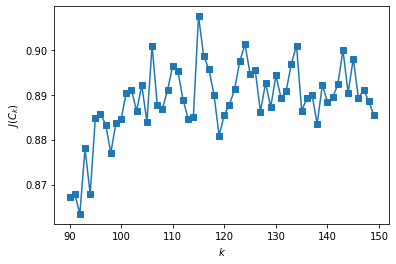

In [0]:
max_f(true_data, X, labels, 'kmeans', 90, 150, 1)

94


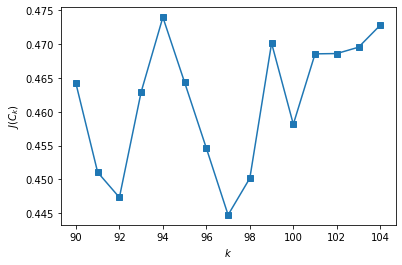

In [0]:
ncluster = silhouette(true_data, X, labels, 'kmeans', 90, 105, 1) 
print(ncluster)

In [0]:
result = kmeans_result(X, 94)
get_fscore(result, dict_lables)


Silhouette Coefficient: 0.481
F-BCubed: 0.869


### DF


In [0]:
def create_csv(true_data,result):
  rows_list = []
  for i in range(0, len(result)):
    c = Counter(result)
    if (c[result[i]]>1):
          dict1 = {}
          dict1.update({"text": true_data[0][i], "num": true_data[1][i], "cluster": result[i] }) 

          rows_list.append(dict1)

  df = pd.DataFrame(rows_list) 
  
  df.to_csv('file_name.csv', index=False)
  !cp file_name.csv "/content/drive/My Drive/cluster_rez"
  print("Saved to disk")


In [0]:
create_csv(true_data, result)

Saved to disk


### spect

0.8971868138936808

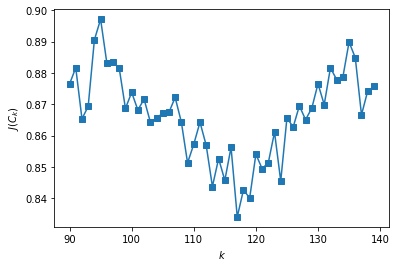

In [0]:
max_f(true_data, X, labels, 'spectr', 90, 140, 1)

82


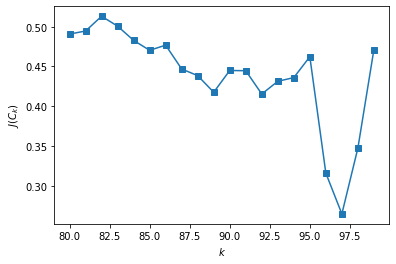

In [0]:
ncluster = silhouette(true_data, X, labels, "spectr", 80, 100, 1)
print(ncluster)

In [0]:
clustering = SpectralClustering(n_clusters=82, affinity="rbf", gamma=0.01,eigen_solver = 'amg',n_init=20).fit(X)
cluster_assignment = clustering.labels_

In [0]:
get_fscore(cluster_assignment, dict_lables)

F-BCubed: 0.870


0.7980164432656167

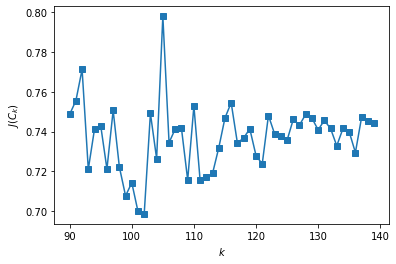

In [0]:
max_f(true_data, X, labels, 'spectr_precomp', 90, 140, 1)

86


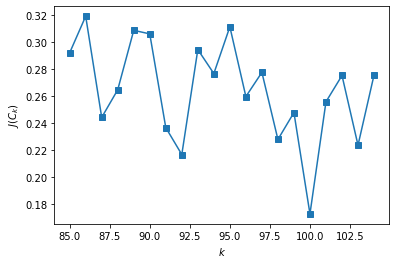

In [0]:
ncluster = silhouette(true_data, X, labels, "spectr_precomp", 85, 105, 1)
print(ncluster)

In [0]:
matrix = get_matrix(X)
clustering = SpectralClustering(n_clusters=86, affinity="precomputed", gamma=0.01).fit(matrix)
cluster_assignment = clustering.labels_

In [0]:
get_fscore(cluster_assignment, dict_lables)

F-BCubed: 0.774


### af prop

In [0]:
matrix = get_matrix(X)
clustering = AffinityPropagation(affinity="precomputed", damping = 0.7, preference = 0.9).fit(matrix)
cluster_assignment = clustering.labels_
print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, cluster_assignment, metric='cosine', sample_size=len(X)))

Silhouette Coefficient: 0.497


In [0]:
get_fscore(cluster_assignment, dict_lables)

F-BCubed: 0.933


## aglom k

0.9343326881837297

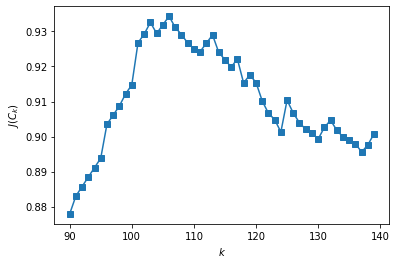

In [0]:
max_f(true_data, X, labels, 'aglom_complete', 90, 140, 1)

92


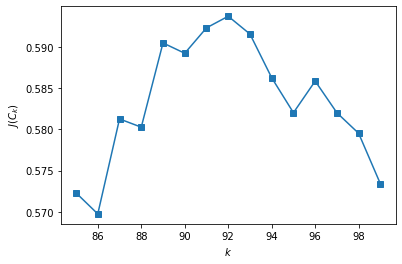

In [0]:
ncluster = silhouette(true_data, X, labels, "aglom_complete", 85, 100, 1)
print(ncluster)

In [0]:
aglom = AgglomerativeClustering(n_clusters = 92, linkage = "complete", affinity = "cosine").fit(X)
cluster_assignment = aglom.labels_
print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, cluster_assignment, metric='cosine', sample_size=len(X)))

Silhouette Coefficient: 0.594


In [0]:
get_fscore(cluster_assignment, dict_lables)

F-BCubed: 0.886


0.9343326881837297

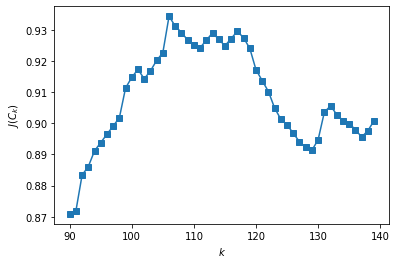

In [0]:
max_f(true_data, X, labels, 'aglom_average', 90, 140, 1)

92


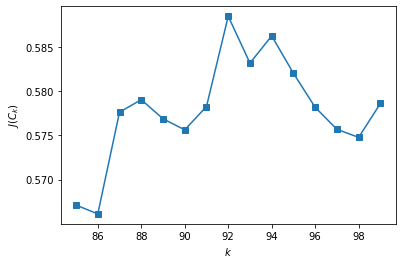

In [0]:
ncluster = silhouette(true_data, X, labels, "aglom_average", 85, 100, 1)
print(ncluster)

In [0]:
aglom = AgglomerativeClustering(n_clusters = 92, linkage = "average", affinity = "cosine").fit(X)
cluster_assignment = aglom.labels_
print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, cluster_assignment, metric='cosine', sample_size=len(X)))

Silhouette Coefficient: 0.588


In [0]:
get_fscore(cluster_assignment, dict_lables)

F-BCubed: 0.883


### aglom threshold

In [0]:
clustering = AgglomerativeClustering( distance_threshold = 0.1, n_clusters = None, linkage = "average", affinity = "cosine").fit(X)
cluster_assignment = clustering.labels_
print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, cluster_assignment, metric='cosine', sample_size=len(X)))
get_fscore(cluster_assignment, dict_lables)

Silhouette Coefficient: 0.520
F-BCubed: 0.927


In [0]:
clustering = AgglomerativeClustering( distance_threshold = 0.1, n_clusters = None, linkage = "complete", affinity = "cosine").fit(X)
cluster_assignment = clustering.labels_
print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, cluster_assignment, metric='cosine', sample_size=len(X)))
get_fscore(cluster_assignment, dict_lables)

Silhouette Coefficient: 0.520
F-BCubed: 0.927


### dbsan

In [0]:
clustering = DBSCAN(eps = 0.1, min_samples = 1, metric="cosine", algorithm= "auto" ).fit(X)
cluster_assignment = clustering.labels_
print("Silhouette Coefficient: %0.3f"
        % metrics.silhouette_score(X, cluster_assignment, metric='cosine', sample_size=len(X)))
get_fscore(cluster_assignment, dict_lables)

Silhouette Coefficient: 0.524
F-BCubed: 0.913
